In [1]:
region_name = "ALL_10-800"  #"TDS" #"CAINGSGII_10-800"  #"TDS" #"WD" #"MDIS_10-800" # "TDS_ELAISN1"
region_dir_name = "./vasca_pipeline/"+region_name+"/"
region_fname = region_dir_name+"region_"+region_name+"_cat.fits"
rg_src_id = 357455

From https://arxiv.org/pdf/2106.07669.pdf

𝐴𝐺 = 0.835𝐴𝑉 (31)
𝐴𝐺BP = 1.139𝐴𝑉 (32)
𝐴𝐺RP = 0.650𝐴𝑉 (33)

In [2]:
AV = 0.01
AG= 0.835*AV
dBPmRp = (1.139+0.650)*AV
print(AG,dBPmRp)

0.00835 0.017890000000000003


In [3]:
from __future__ import print_function
from astropy.coordinates import SkyCoord

from dustmaps.config import config
config['data_dir'] = './resources/dustmaps'
from dustmaps.edenhofer2023 import Edenhofer2023Query
import astropy.units as units

coords = SkyCoord(12.3*units.deg, -25.4*units.deg,
                  distance=99.6056*units.pc, frame="icrs")
edenhofer = Edenhofer2023Query(integrated=True)

ebv = edenhofer(coords)

print(ebv)

Integrating extinction map (this might take a couple of minutes)...
Optimizing map for querying (this might take a couple of seconds)...


0.007744406055593374


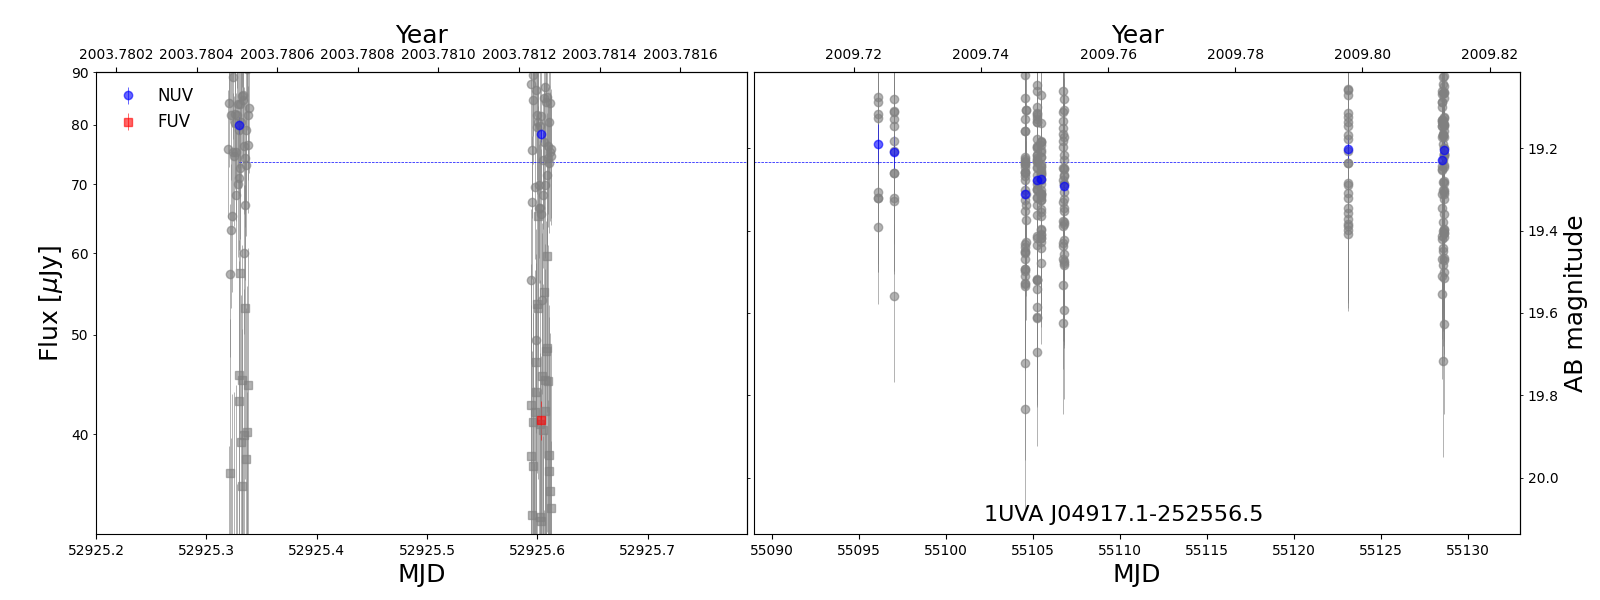

In [4]:
%matplotlib widget
import ipywidgets as widgets
from IPython.display import display
import matplotlib.pyplot as plt
from vasca.utils import get_lc_from_gphoton_npfile
from vasca.region import Region
import vasca.visualization as vvis
from vasca.utils import run_LombScargle
from astropy import units as uu
from matplotlib.ticker import ScalarFormatter, FuncFormatter
import numpy as np

#display(tt_gp_lc)

#Get source
rg = Region()
rg.load_from_fits(region_fname)
tc_src = rg.get_src_from_id(rg_src_id, load_from_file = False, add_sed=False,add_gphoton=False, add_spectrum=False)
tc_src.add_gphoton_lc(s2n_min=2.0, tbin = 40)


#Plot LC
fig, axs = plt.subplots(1, 2, figsize=(16, 6),num="LC", clear=True, gridspec_kw={'width_ratios': [1.7, 2]})
axs = axs.flatten()
_ = vvis.plot_light_curve(tc_src, ax = axs[0])

def scientific(xx, pos):
    # xx:  tick value - ie. what you currently see in yticks
    # pos: a position - ie. the index of the tick (from 0 to 9 in this example)
    return str(np.round(xx,2))

scientific_formatter = FuncFormatter(scientific)
axs[0].xaxis.set_major_formatter(scientific_formatter)

axs[0].set_xlim([52925.2, 52925.79])
axs[0].set_ylim([3.2e1, 9e1])
#axs[0].grid(linestyle = '--') #
axs[0].texts[0].remove()
    
_ = vvis.plot_light_curve(tc_src, ax = axs[1])
axs[1].set_xlim([55089, 55133])
axs[1].set_ylim([3.2e1, 9e1])
axs[1].get_legend().remove()
y_axis = axs[1].axes.get_yaxis()
y_axis.set_visible(False)

plt.subplots_adjust(left=0.06, bottom=None, right=0.95, top=None, wspace=0.01, hspace=None)
plt.show()

fig.savefig(region_dir_name +"LC_"+str(rg_src_id)+".pdf")

83
65.913086


/home/buehler/Code/vasca/vasca/visualization.py:1213: RuntimeWarning: divide by zero encountered in divide
  dfs = 1 / dtimes.flatten()
/home/buehler/Code/vasca/vasca/utils.py:357: RuntimeWarning: divide by zero encountered in divide
  return 1 / pp


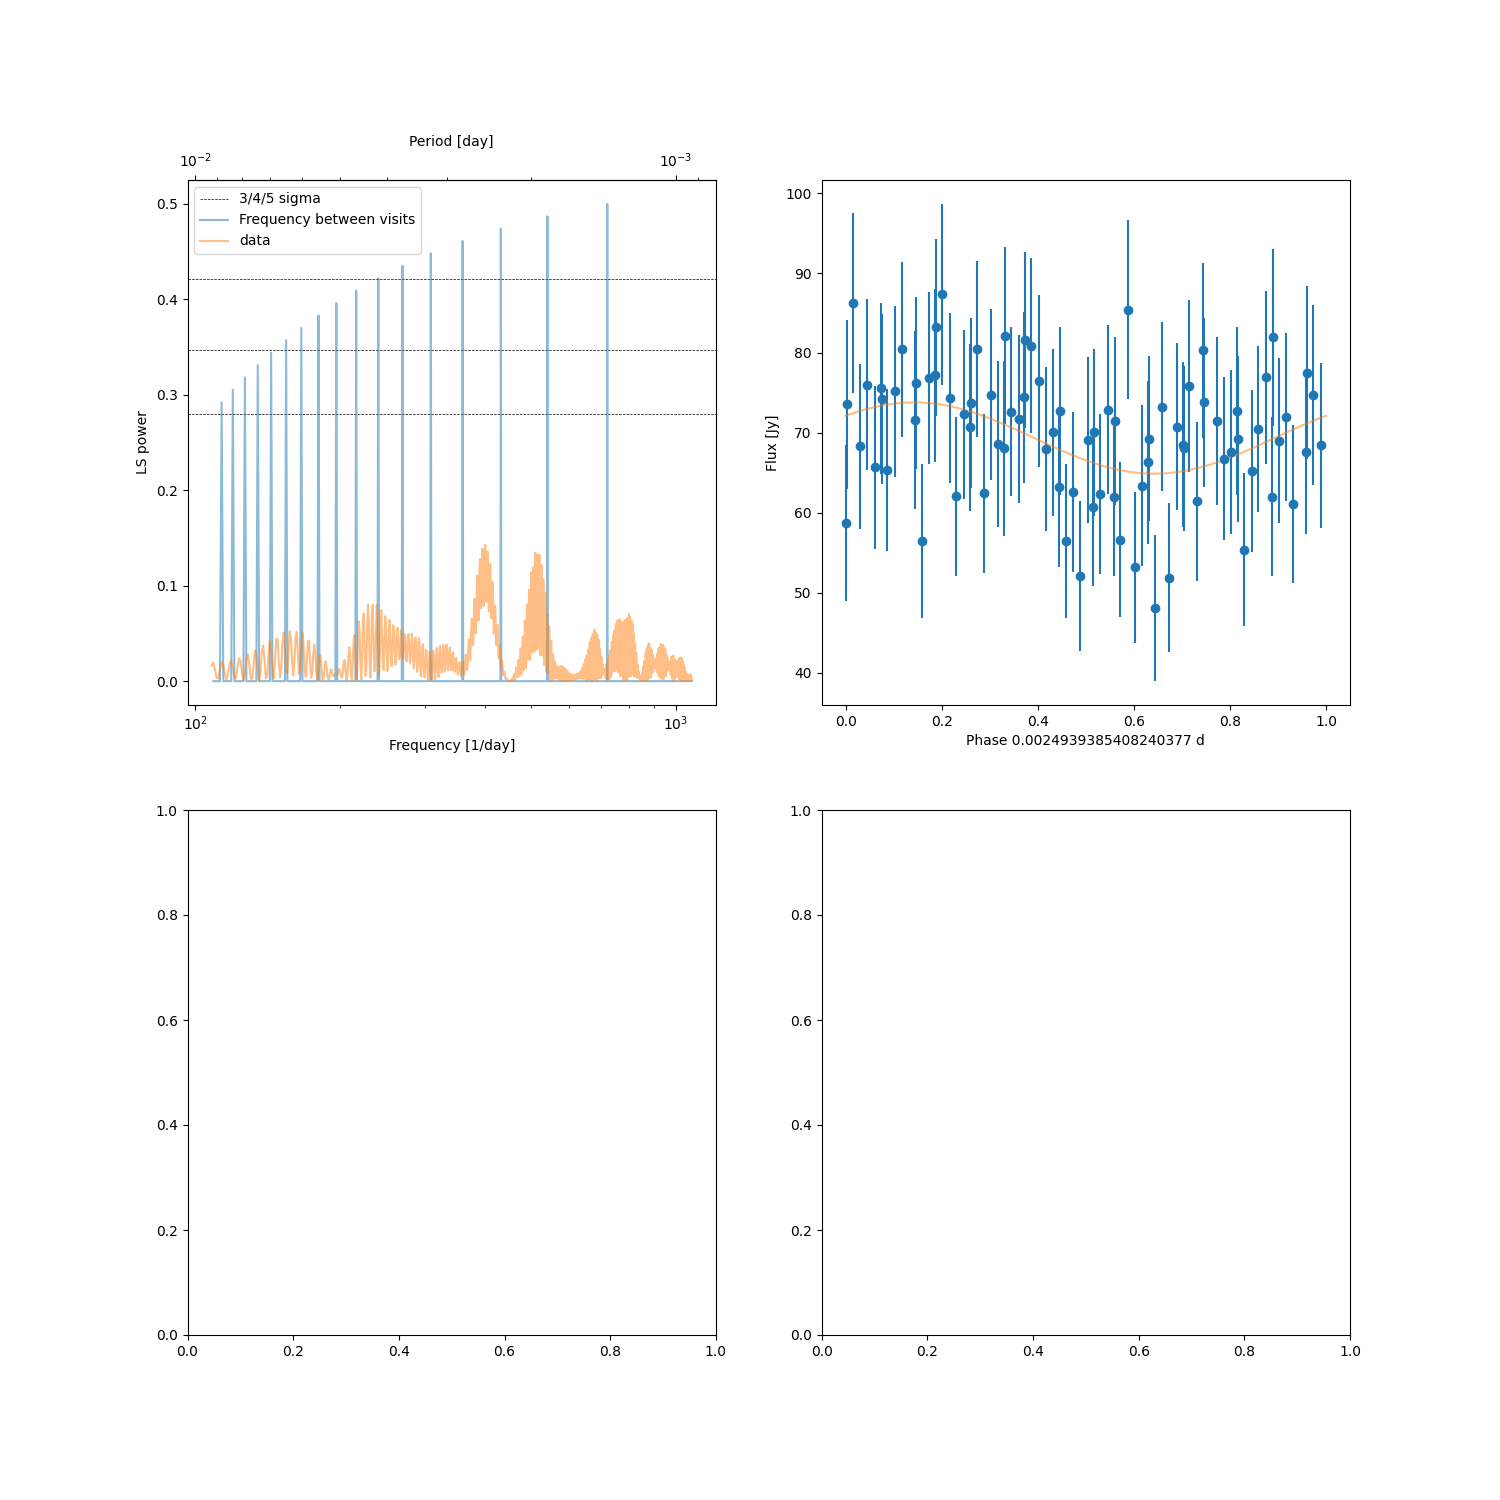

In [5]:
fig_ls, axs_ls = plt.subplots(2,2,figsize=(15, 15),squeeze=True, num="LS ", clear=True)
axs_ls = axs_ls.flatten()

#Add artificial variations
flux = tc_src.tt_gphoton_lc["flux"]
times = tc_src.tt_gphoton_lc["time"]
mean_flux = np.mean(flux)
period = 220.44 / (24*60*60)

#tc_src.tt_gphoton_lc["flux"] = flux + 0.08*mean_flux*np.sin(2*np.pi*times/period)
sel = (tc_src.tt_gphoton_lc["time"] > 55100) * (tc_src.tt_gphoton_lc["time"] < 55110)  # Low flux window
#sel = (tc_src.tt_gphoton_lc["time"] > 55105) * (tc_src.tt_gphoton_lc["time"] < 55106)  # Low flux window
print(sel.sum())
tc_src.tt_gphoton_lc["sel"] = sel

#print(flux,tc_src.tt_gphoton_lc["flux"])

fig, ax, dd_ls_results_nuv = vvis.plot_lombscargle(tc_src.tt_gphoton_lc, ax=axs_ls[0], ax_phase = axs_ls[1], freq_range = [108,1080]/ uu.d ) #, ax_lc = axs[0]
#fig, ax, dd_ls_results_fuv =  vvis.plot_lombscargle(tc_src.tt_gphoton_lc, ax=axs_ls[2],obs_filter="FUV", ax_phase = axs_ls[3], freq_range = [24,1080]/ uu.d)
print(mean_flux)
plt.show()

In [6]:
period = 220/(24*60*60)
freq = 1/period
print(period,freq)

0.0025462962962962965 392.7272727272727


In [7]:
#tt_lc = tc_src.tt_gphoton_lc[tc_src.tt_gphoton_lc["obs_filter"]=="NUV"]
#print(tt_lc)
#dd_ls_results = run_LombScargle(tt_lc,nbins_min=10,freq_range=[0.001, 10] / uu.d)
#print(dd_ls_results)


In [8]:
# from dustmaps.config import config
# config['data_dir'] = './resources/dustmaps'
# import dustmaps.edenhofer2023
# dustmaps.edenhofer2023.fetch()


In [9]:
(24*60*60)

86400

In [10]:
(24*60*60)/(2*40)

1080.0